In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# functions
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(temp, last_point, measure): 
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

def compute_seahorse_measures_per_well(well_id, df_sub):
    temp = df_sub[df_sub['Well']==well_id]
    integrals = [compute_integral(temp, x, 'OCR') for x in range(2,13)]
    non_mito = np.sum(integrals[9:11])
    basal = np.sum(integrals[0:2]) - non_mito
    proton_leak = np.sum(integrals[3:5]) - non_mito
    atp_linked = basal-proton_leak
    max_resp = np.sum(integrals[6:8]) - non_mito
    
    CE = atp_linked/basal
    SRC = basal/max_resp
    ATP_of_MAX = atp_linked/max_resp

    return CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette):
    
    ax = sns.boxplot(data = d, x = x_val, showfliers=False, y = y_val, palette = palette, dodge = True, order = order, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x= x_val, y=y_val, dodge=True, jitter=True, alpha=1,  order = order, palette = palette)

     # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order =order)
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')

###### Experiment: iN030620240_ABCA7KO_CDP-choline_04032024

In [2]:
# load data
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

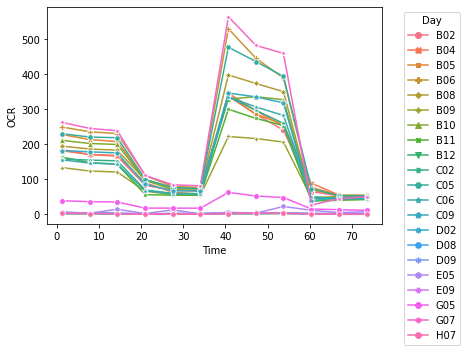

In [3]:
keep = []
discard = []
for i in np.unique(df['Well']):
    x = df[df['Well']==i]
    cond1 = (float(x[x['Measurement']==4]['OCR'])-float(x[x['Measurement']==3]['OCR']))< -.45*float(x[x['Measurement']==3]['OCR'])#((float(x[x['Measurement']==3]['OCR']))-.5*float(x[x['Measurement']==3]['OCR']))
    cond2 = (float(x[x['Measurement']==7]['OCR'])-float(x[x['Measurement']==6]['OCR']))>.45*float(x[x['Measurement']==6]['OCR'])
    cond3 = (float(x[x['Measurement']==10]['OCR'])-float(x[x['Measurement']==9]['OCR']))<0
    cond4 = (float(x[x['Measurement']==1]['OCR'])>0)

    if (cond1 & cond2 & cond3 & cond4):
        keep.append(i)
    else:
        discard.append(i)
        
df_sub = df[[x in set(keep) for x in df['Well']]]

sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Well', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_cdp.pdf')

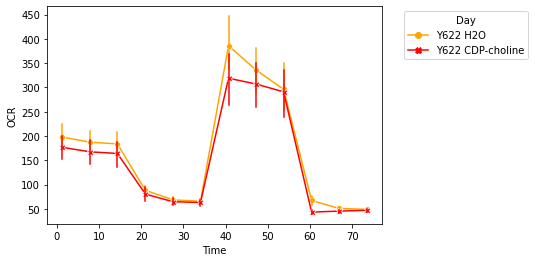

In [41]:

df_sub = df_sub[[x in set(['Y622 H2O', 'Y622 CDP-choline']) for x in df_sub['Group']]]

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', markers=True, dashes=False, ci=95, err_style='bars', palette = ['orange', 'red'])  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_cdp2.pdf')

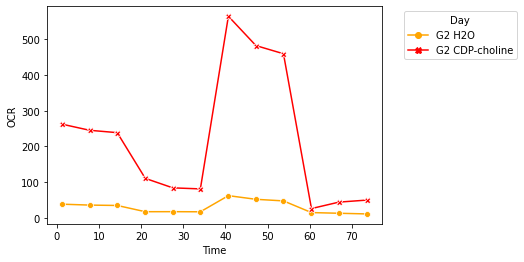

In [4]:

df_sub = df_sub[[x in set(['G2 H2O', 'G2 CDP-choline']) for x in df_sub['Group']]]

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', markers=True, dashes=False, ci=95, err_style='bars', palette = ['orange', 'red'])  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig('../pdf_figures/example_traces_cdp2.pdf')

In [5]:
dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df = pd.DataFrame(out)
df.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df['1-CE'] = 1-df['CE']

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error

G2 H2O vs. G2 CDP-choline: t-test independent samples, P_val:nan t=nan


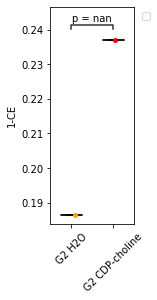

In [6]:
order = ['G2 H2O', 'G2 CDP-choline']
pairs = [(('G2 H2O'), ('G2 CDP-choline'))]
plt.figure(figsize=(1.5,4))

plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, ['orange', 'red']) 

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 H2O vs. Y622 CDP-choline: t-test independent samples, P_val:2.518e-02 t=-2.630e+00


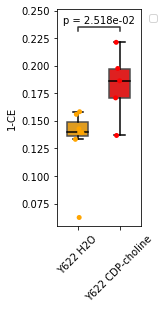

In [15]:
order = ['Y622 H2O', 'Y622 CDP-choline']
pairs = [(('Y622 H2O'), ('Y622 CDP-choline'))]
plt.figure(figsize=(1.5,4))

plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, ['orange', 'red']) 
plt.savefig('../pdf_figures/example_traces_cdp_ce.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 H2O vs. Y622 CDP-choline: t-test independent samples, P_val:9.022e-01 t=1.260e-01


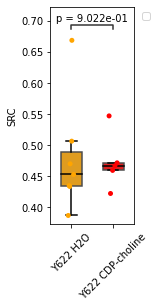

In [16]:
order = ['Y622 H2O', 'Y622 CDP-choline']
pairs = [(('Y622 H2O'), ('Y622 CDP-choline'))]
plt.figure(figsize=(1.5,4))

plot_boxplot_by_treatment(df, 'condition', 'SRC', order, pairs, ['orange', 'red']) 
plt.savefig('../pdf_figures/example_traces_SRC_ce.pdf')

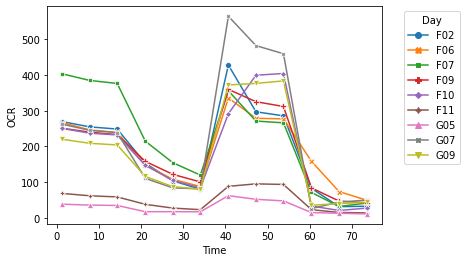

In [38]:
# load data
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

keep = []
discard = []
for i in np.unique(df['Well']):
    x = df[df['Well']==i]
    cond1 = (float(x[x['Measurement']==4]['OCR'])-float(x[x['Measurement']==3]['OCR']))< -.3*float(x[x['Measurement']==3]['OCR'])#((float(x[x['Measurement']==3]['OCR']))-.5*float(x[x['Measurement']==3]['OCR']))
    cond2 = (float(x[x['Measurement']==7]['OCR'])-float(x[x['Measurement']==6]['OCR']))>0*float(x[x['Measurement']==6]['OCR'])
    cond3 = (float(x[x['Measurement']==10]['OCR'])-float(x[x['Measurement']==9]['OCR']))<0
    cond4 = (float(x[x['Measurement']==1]['OCR'])>0)

    if (cond1 & cond2 & cond3 & cond4):
        keep.append(i)
    else:
        discard.append(i)
        
df_sub = df[[x in set(keep) for x in df['Well']]]

df_sub = df_sub[[x in set(['G2 H2O', 'G2 CDP-choline']) for x in df_sub['Group']]]


sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Well', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig('../pdf_figures/example_traces_cdp.pdf')



/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/stats/StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


G2 H2O vs. G2 CDP-choline: t-test independent samples, P_val:nan t=nan


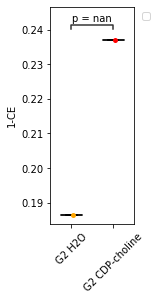

In [25]:
order = ['G2 H2O', 'G2 CDP-choline']
pairs = [(('G2 H2O'), ('G2 CDP-choline'))]
plt.figure(figsize=(1.5,4))

plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, ['orange', 'red']) 
#plt.savefig('../pdf_figures/example_traces_SRC_ce.pdf')

In [ ]:
order = ['Y622 H2O', 'Y622 CDP-choline']
pairs = [(('Y622 H2O'), ('Y622 CDP-choline'))]
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, ['orange', 'forestgreen']) 
plt.savefig('../pdf_figures/example_traces_cdp_ce.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 H2O vs. Y622 CDP-choline: t-test independent samples, P_val:9.022e-01 t=1.260e-01


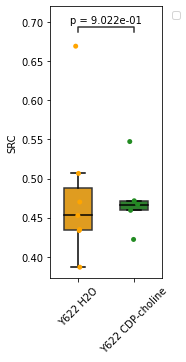

In [284]:
df.groupby(['condition']).mean()

,CE,SRC,ATP_of_MAX,basal,proton_leak,atp_linked,max_resp,1-CE
condition,,,,,,,,
Y622 CDP-choline,0.817420,0.473484,0.387352,1607.748993,298.469915,1309.279078,3403.787411,0.182580
Y622 H2O,0.866861,0.479121,0.415598,1749.766984,236.736974,1513.030009,3708.032011,0.133139


###### Experiment: iN_ABCA7KO_50k_25k_03272024_iNbatch02282024

In [253]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [153]:
#df = df[['25k' in x for x in df['Group']]]

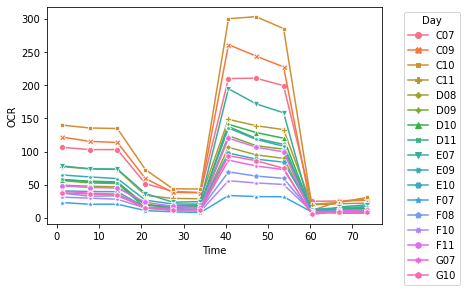

In [254]:
keep = []
discard = []
for i in np.unique(df['Well']):
    x = df[df['Well']==i]
    cond1 = (float(x[x['Measurement']==4]['OCR'])-float(x[x['Measurement']==3]['OCR']))< -.45*float(x[x['Measurement']==3]['OCR'])#((float(x[x['Measurement']==3]['OCR']))-.5*float(x[x['Measurement']==3]['OCR']))
    cond2 = (float(x[x['Measurement']==7]['OCR'])-float(x[x['Measurement']==6]['OCR']))>.45*float(x[x['Measurement']==6]['OCR'])
    cond3 = (float(x[x['Measurement']==10]['OCR'])-float(x[x['Measurement']==9]['OCR']))<0
    cond4 = (float(x[x['Measurement']==1]['OCR'])>0)

    if (cond1 & cond2 & cond3 & cond4):
        keep.append(i)
    else:
        discard.append(i)
        
df_sub = df[[x in set(keep) for x in df['Well']]]

sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Well', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_0327.pdf')

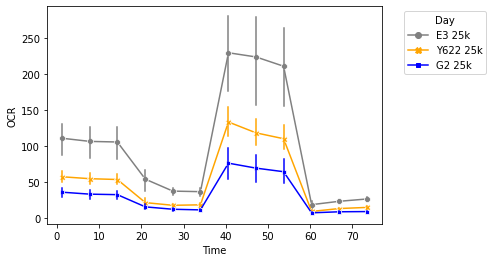

In [256]:

df_sub = df_sub[['25k' in x for x in df_sub['Group']]]

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', markers=True, dashes=False, ci=95, err_style='bars', palette=['grey', 'orange', 'blue'])  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_0327_2.pdf')

In [257]:
dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df = pd.DataFrame(out)
df.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df['1-CE'] = 1-df['CE']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:5.564e-03 t=3.621e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:7.250e-02 t=2.068e+00


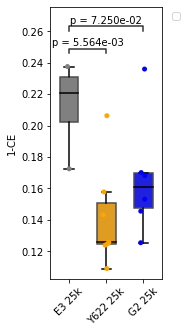

In [261]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
plt.figure(figsize=(2,5))

palette = palette=['grey', 'orange', 'blue']
plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, palette) 
plt.savefig('../pdf_figures/example_traces_0327_ce.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.190e-01 t=1.723e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.521e-01 t=-1.926e-01


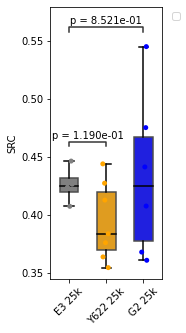

In [262]:
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df, 'condition', 'SRC', order, pairs, palette) 
plt.savefig('../pdf_figures/example_traces_0327_SRC.pdf')

In [263]:
df_batch1 = df

###### Experiment: iN_ABCA7KO_50k_25k_03132024

In [264]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

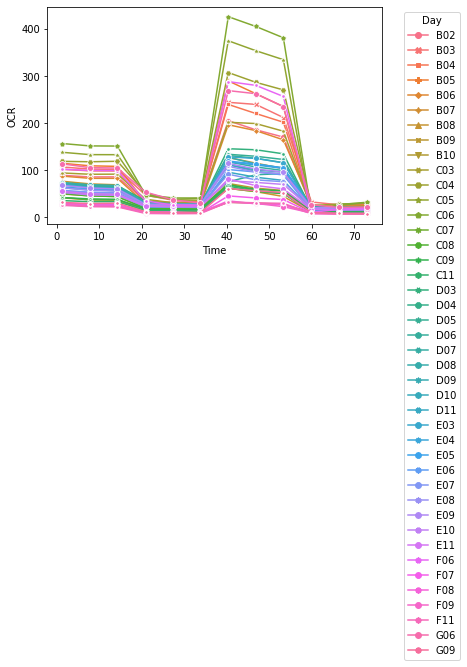

In [265]:
keep = []
discard = []
for i in np.unique(df['Well']):
    x = df[df['Well']==i]
    cond1 = (float(x[x['Measurement']==4]['OCR'])-float(x[x['Measurement']==3]['OCR']))< -.45*float(x[x['Measurement']==3]['OCR'])#((float(x[x['Measurement']==3]['OCR']))-.5*float(x[x['Measurement']==3]['OCR']))
    cond2 = (float(x[x['Measurement']==7]['OCR'])-float(x[x['Measurement']==6]['OCR']))>.45*float(x[x['Measurement']==6]['OCR'])
    cond3 = (float(x[x['Measurement']==10]['OCR'])-float(x[x['Measurement']==9]['OCR']))<0
    cond4 = (float(x[x['Measurement']==1]['OCR'])>25)

    if (cond1 & cond2 & cond3 & cond4):
        keep.append(i)
    else:
        discard.append(i)
        
df_sub = df[[x in set(keep) for x in df['Well']]]

sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Well', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_0313.pdf')

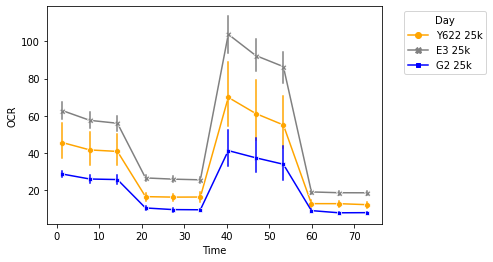

In [267]:
df_sub = df_sub[['25k' in x for x in df_sub['Group']]]

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', markers=True, dashes=False, ci=95, err_style='bars', palette=[ 'orange','grey', 'blue'])  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../pdf_figures/example_traces_0313_2.pdf')

In [268]:
dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp])
    
df = pd.DataFrame(out)
df.columns = ['condition', 'CE', 'SRC', 'ATP_of_MAX', 'basal', 'proton_leak', 'atp_linked', 'max_resp']
df['1-CE'] = 1-df['CE']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:7.233e-06 t=6.507e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.346e-06 t=7.524e+00


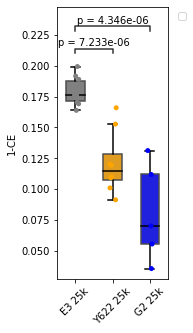

In [269]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs, palette) 
plt.savefig('../pdf_figures/example_traces_0313_CD.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.005e-02 t=-2.582e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.437e-02 t=-2.546e+00


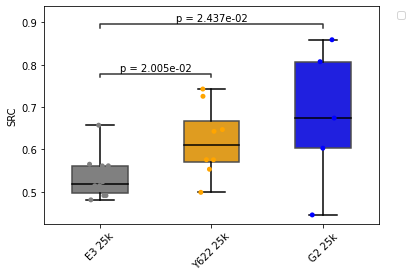

In [270]:
plot_boxplot_by_treatment(df, 'condition', 'SRC', order, pairs, palette) 
plt.savefig('../pdf_figures/example_traces_0313_SRC.pdf')

In [271]:
df_batch2 = df

#### both batches

In [272]:
df_both = pd.concat((df_batch1, df_batch2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.912e-06 t=5.879e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.327e-03 t=3.653e+00


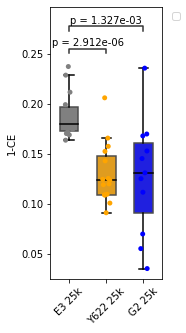

In [273]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_both, 'condition', '1-CE', order, pairs, palette) 
plt.savefig('../pdf_figures/both_batches_CD.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:7.988e-01 t=-2.574e-01
E3 25k vs. G2 25k: t-test independent samples, P_val:4.391e-01 t=-7.873e-01


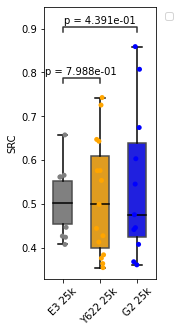

In [274]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')),(('E3 25k'), ('G2 25k'))]
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df_both, 'condition', 'SRC', order, pairs, palette) 
plt.savefig('../pdf_figures/both_batches_SRC.pdf')

In [285]:
df_both.groupby(['condition']).mean()

,CE,SRC,ATP_of_MAX,basal,proton_leak,atp_linked,max_resp,1-CE
condition,,,,,,,,
E3 25k,0.810981,0.504732,0.409990,682.223686,134.662660,547.561026,1438.138546,0.189019
G2 25k,0.872510,0.544262,0.480793,288.089130,40.355576,247.733554,610.637632,0.127490
Y622 25k,0.869322,0.514946,0.448674,464.124072,62.843017,401.281056,995.793999,0.130678


#### cartoon

/state/partition1/slurm_tmp/25916258.0.0/ipykernel_617641/97963081.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub2['OCR'] = (df_sub2['OCR'] - non_mito) / basal


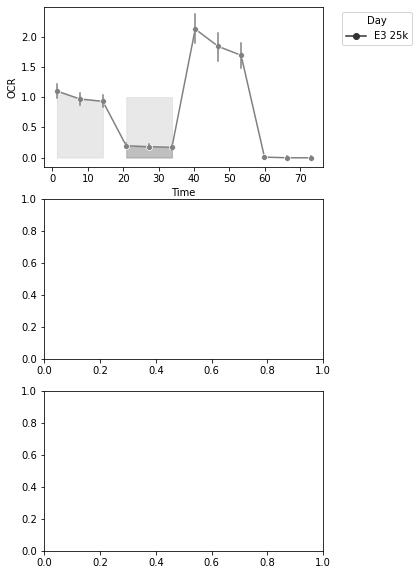

In [227]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

col = ['Grey', 'Orange', 'Blue']

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_sub['Well']]]


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))

for n, i in enumerate(['E3 25k']):
    #n=0
    df_sub2 = df_sub[df_sub['Group']==i]

    # get mean vals
    mean_ocr = df_sub2.groupby(['Group', 'Measurement', 'Time'])['OCR'].mean().reset_index()
    non_mito = np.mean(mean_ocr['OCR'][mean_ocr['Measurement']>9])
    basal = np.mean(mean_ocr['OCR'][mean_ocr['Measurement']<4])-non_mito

    df_sub2['OCR'] = (df_sub2['OCR'] - non_mito) / basal

    # show line plot
    sns.lineplot(ax = axes[n], data=df_sub2, x='Time', y='OCR', style='Group', color = col[n], markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


    y = np.array(mean_ocr['OCR']) - non_mito
    x = np.array(mean_ocr['Time']) 
    axes[n].fill_between(x, y/basal, where=(x > 0) & (x < 15), color='lightgrey', alpha=0.5)
    axes[n].fill_between(x, y/basal, where=(x > 15) & (x < 35), color='grey', alpha=.5)

    axes[n].fill_between(x, (basal/basal), y2 = y/basal, where=(x > 15) & (x < 35), color='lightgrey', alpha=0.5)


    axes[n].legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
    #axes[n].set_xlim(0,35)
    #axes[n].set_ylim(0,1.2)
    
#plt.savefig('../pdf_figures/seahorse_overview.pdf')

## below is scrap

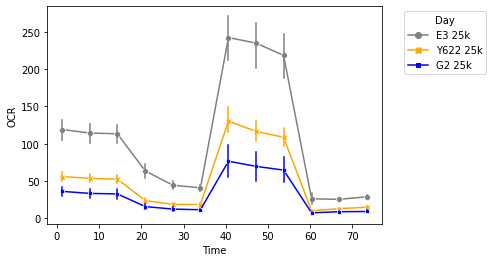

In [20]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

col = ['Grey', 'Orange', 'Blue']
# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_sub['Well']]]

# get mean vals
mean_ocr = df_sub.groupby(['Group', 'Measurement', 'Time'])['OCR'].mean().reset_index()

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', palette = col, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


# plot fill between
for n, i in enumerate(np.unique(mean_ocr['Group'])):
    temp = mean_ocr[mean_ocr['Group']==i]

    integrals = [compute_integral(temp, x, 'OCR') for x in range(2,13)]

    non_mito = np.mean(integrals[9:11])

    y = np.array(temp['OCR'])
    x = np.array(temp['Time'])
    plt.fill_between(x, y, where=(x > 0) & (x < 15) & (y>non_mito), color=col[n], alpha=0.5)

plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')

In [22]:
# compute internally-normalized measures
## Coupling efficiency: ATP-linked OCR / basal OCR = the fraction used to drive ATP synthesis
## Respiratory control Rate: maximal respiration / proton leak 
## ATP-linked respiration / maximal respiration = how close is cell to making ATP at its max rate 

dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, RCR, ATP_of_MAX, d, e, f, g = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, RCR, ATP_of_MAX])
    
df = pd.DataFrame(out)
df.columns = ['condition', 'CE', 'RCR', 'ATP_of_MAX']
df['1-CE'] = 1-df['CE']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
Y622 25k vs. G2 25k: t-test independent samples, P_val:7.733e-01 t=2.937e-01
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00
E3 25k vs. Y622 25k: t-test independent samples, P_val:2.076e-03 t=3.629e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 25k vs. G2 25k: t-test independent samples, P_val:1.017e-01 t=-1.752e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:9.128e-01 t=-1.116e-01
E3 25k vs. Y622 25k: t-test independent samples, P_val:7.456e-01 t=3.297e-01
Y622 25k vs. G2 25k: t-test independent samples, P_val:1.514e-01 t=-1.518e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. G2 25k: t-test independent samples, P_val:1.809e-01 t=-1.414e+00


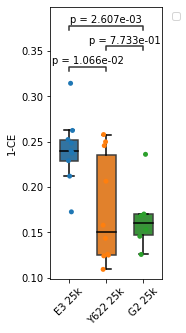

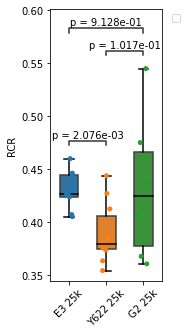

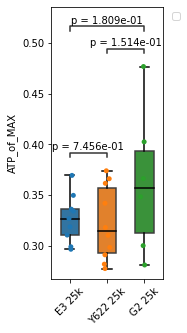

In [23]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')), (('E3 25k'), ('G2 25k')), ( ('Y622 25k'),  ('G2 25k'))]
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs) 
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', 'RCR', order, pairs) 
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', 'ATP_of_MAX', order, pairs) 

###### Experiment: both batches

In [ ]:
# have Shannon click through and remove wells that didn't work (blinded)
# for choline treatment perhaps can plot more parameters?

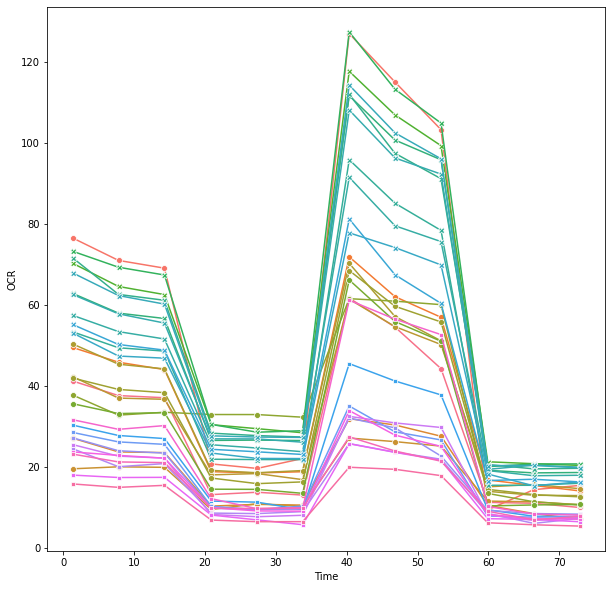

In [24]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
#df_sub = df_sub[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_sub['Well']]]

# show line plot
#df_sub = df_sub[df_sub['Group'] =='Y622 25k']
plt.figure(figsize=(10,10))
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Group', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend().remove()


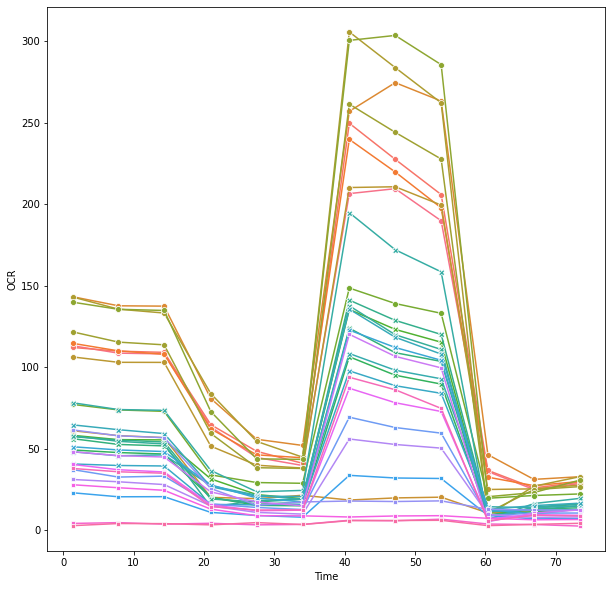

In [195]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
#df_sub = df_sub[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_sub['Well']]]

# show line plot
#df_sub = df_sub[df_sub['Group'] =='Y622 25k']
plt.figure(figsize=(10,10))
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Well', style='Group', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend().remove()


In [29]:
## combine both batches

# batch 1
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_sub['Well']]]

dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, RCR, ATP_of_MAX, x, y, z, d = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, RCR, ATP_of_MAX])
    
df1 = pd.DataFrame(out)
df1.columns = ['condition', 'CE', 'RCR', 'ATP_of_MAX']
df1['1-CE'] = 1-df1['CE']

# batch 2 
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_sub['Well']]]


dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, RCR, ATP_of_MAX, x, y, z, d  = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, RCR, ATP_of_MAX])
    
df2 = pd.DataFrame(out)
df2.columns = ['condition', 'CE', 'RCR', 'ATP_of_MAX']
df2['1-CE'] = 1-df2['CE']

In [30]:
df1['batch'] = 1
df2['batch'] = 2
temp = pd.concat([df1, df2], axis=0)

In [31]:
temp.head()

,condition,CE,RCR,ATP_of_MAX,1-CE,batch
0,E3 25k,0.760106,0.460122,0.349742,0.239894,1
1,E3 25k,0.737712,0.405385,0.299058,0.262288,1
2,E3 25k,0.747801,0.426256,0.318755,0.252199,1
3,E3 25k,0.751549,0.444595,0.334135,0.248451,1
4,E3 25k,0.788119,0.426477,0.336115,0.211881,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:4.851e-01 t=7.052e-01
Y622 25k vs. G2 25k: t-test independent samples, P_val:2.324e-01 t=1.216e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.673e-06 t=5.465e+00
E3 25k vs. Y622 25k: t-test independent samples, P_val:7.157e-02 t=-1.915e+00
Y622 25k vs. G2 25k: t-test independent samples, P_val:3.353e-02 t=-2.301e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. G2 25k: t-test independent samples, P_val:8.664e-04 t=-3.986e+00
E3 25k vs. Y622 25k: t-test independent samples, P_val:5.015e-01 t=-6.787e-01
Y622 25k vs. G2 25k: t-test independent samples, P_val:2.286e-02 t=-2.384e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.835e-04 t=-3.656e+00


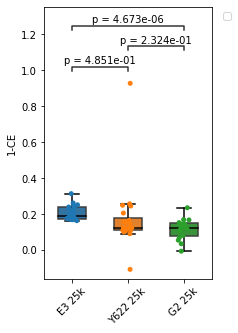

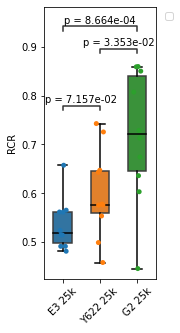

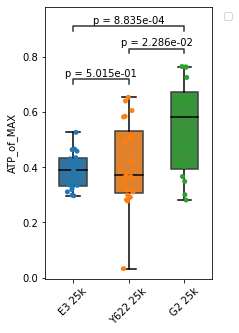

In [34]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')), (('E3 25k'), ('G2 25k')), ( ('Y622 25k'),  ('G2 25k'))]
plt.figure(figsize=(3,5))
plot_boxplot_by_treatment(temp, 'condition', '1-CE', order, pairs) 
#plt.ylim(0,0.4)
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(temp[temp['batch']==2], 'condition', 'RCR', order, pairs) 
plt.figure(figsize=(3,5))
plot_boxplot_by_treatment(temp, 'condition', 'ATP_of_MAX', order, pairs) 

###### Experiment: iN_ABCA7KO_50k_25k_03132024

/state/partition1/slurm_tmp/25822102.0.0/ipykernel_3969403/362504366.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub2['OCR'] = (df_sub2['OCR'] - non_mito) / basal


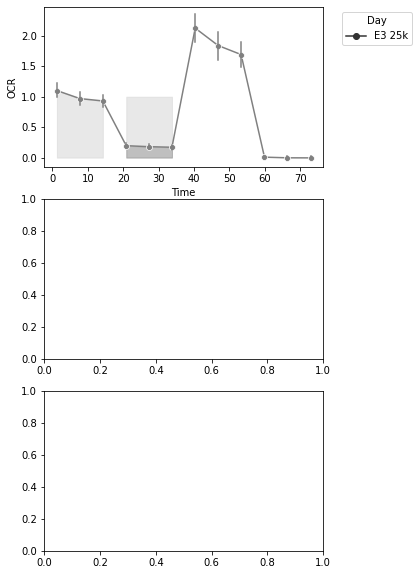

In [145]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

col = ['Grey', 'Orange', 'Blue']

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_sub['Well']]]


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))

for n, i in enumerate(['E3 25k']):
    #n=0
    df_sub2 = df_sub[df_sub['Group']==i]

    # get mean vals
    mean_ocr = df_sub2.groupby(['Group', 'Measurement', 'Time'])['OCR'].mean().reset_index()
    non_mito = np.mean(mean_ocr['OCR'][mean_ocr['Measurement']>9])
    basal = np.mean(mean_ocr['OCR'][mean_ocr['Measurement']<4])-non_mito

    df_sub2['OCR'] = (df_sub2['OCR'] - non_mito) / basal

    # show line plot
    sns.lineplot(ax = axes[n], data=df_sub2, x='Time', y='OCR', style='Group', color = col[n], markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


    y = np.array(mean_ocr['OCR']) - non_mito
    x = np.array(mean_ocr['Time']) 
    axes[n].fill_between(x, y/basal, where=(x > 0) & (x < 15), color='lightgrey', alpha=0.5)
    axes[n].fill_between(x, y/basal, where=(x > 15) & (x < 35), color='grey', alpha=.5)

    axes[n].fill_between(x, (basal/basal), y2 = y/basal, where=(x > 15) & (x < 35), color='lightgrey', alpha=0.5)


    axes[n].legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')
    #axes[n].set_xlim(0,35)
    #axes[n].set_ylim(0,1.2)
    
plt.savefig('../pdf_figures/seahorse_overview.pdf')

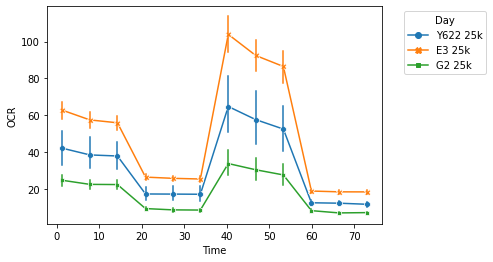

In [172]:
# load data
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

# subset by 25k because 50k were clumping
df_sub = df[['25k' in x for x in df['Group']]]
df_sub = df_sub[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_sub['Well']]]

# show line plot
sns.lineplot(data=df_sub, x='Time', y='OCR', hue='Group', style='Group', markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')

In [173]:
# compute internally-normalized measures
## Coupling efficiency: ATP-linked OCR / basal OCR = the fraction used to drive ATP synthesis
## Respiratory control Rate: maximal respiration / proton leak 
## ATP-linked respiration / maximal respiration = how close is cell to making ATP at its max rate 

dictionary = dict(zip(df_sub['Well'], df_sub['Group']))

out = []

for well in np.unique(df_sub['Well']):
    
    CE, RCR, ATP_of_MAX = compute_seahorse_measures_per_well(well, df_sub)
    condition = dictionary[well]
    out.append([condition, CE, RCR, ATP_of_MAX])
    
df = pd.DataFrame(out)
df.columns = ['condition', 'CE', 'RCR', 'ATP_of_MAX']
df['1-CE'] = 1-df['CE']

In [118]:
np.unique(df['condition'])

array(['E3 25k', 'G2 25k', 'Y622 25k'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=5.279e-03
Y622 25k vs. G2 25k: t-test independent samples, P_val:3.009e-01 t=1.065e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=6.100e+00
E3 25k vs. Y622 25k: t-test independent samples, P_val:8.262e-01 t=2.227e-01
Y622 25k vs. G2 25k: t-test independent samples, P_val:5.013e-01 t=6.862e-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. G2 25k: t-test independent samples, P_val:4.835e-01 t=7.155e-01
E3 25k vs. Y622 25k: t-test independent samples, P_val:2.907e-01 t=-1.088e+00
Y622 25k vs. G2 25k: t-test independent samples, P_val:3.786e-02 t=-2.241e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.367e-05 t=-5.642e+00


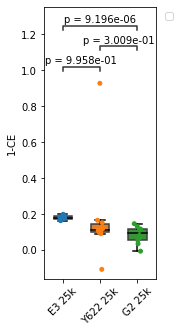

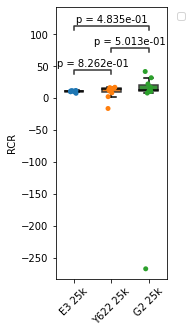

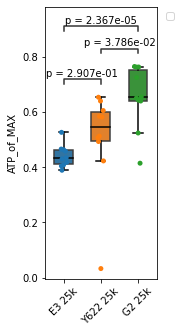

In [174]:
order = ['E3 25k', 'Y622 25k', 'G2 25k']
pairs = [(('E3 25k'), ('Y622 25k')), (('E3 25k'), ('G2 25k')), ( ('Y622 25k'),  ('G2 25k'))]
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', '1-CE', order, pairs) 
#plt.ylim(0,0.4)
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', 'RCR', order, pairs) 
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'condition', 'ATP_of_MAX', order, pairs) 

In [110]:
np.sum(temp[[x in set([1,2,3]) for x in temp['Measurement']]]['OCR'])

216.79462062326508

In [7]:
# functions
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(temp, last_point, measure): 
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

def compute_seahorse_measures_per_well(well_id, df_sub):
    temp = df_sub[df_sub['Well']==well_id]
    integrals = [compute_integral(temp, x, 'OCR') for x in range(2,13)]
    non_mito = np.sum(integrals[9:11])
    basal = np.sum(integrals[0:2]) - non_mito
    proton_leak = np.sum(integrals[3:5]) - non_mito
    atp_linked = basal-proton_leak
    max_resp = np.sum(integrals[6:8]) - non_mito
    
    CE = atp_linked/basal
    SRC = basal/max_resp
    ATP_of_MAX = atp_linked/max_resp
#     temp = df_sub[df_sub['Well']==well_id]
#     non_mito = np.sum(temp[[x in set([10,11,12]) for x in temp['Measurement']]]['OCR']) #float(temp[temp['Measurement']==12]['OCR'])
#     basal = np.sum(temp[[x in set([1,2,3]) for x in temp['Measurement']]]['OCR'])- non_mito #float(temp[temp['Measurement']==3]['OCR'])
#     proton_leak = np.sum(temp[[x in set([4,5,6]) for x in temp['Measurement']]]['OCR'])- non_mito #float(temp[temp['Measurement']==6]['OCR']) 
#     atp_linked = basal-proton_leak
#     max_resp = np.sum(temp[[x in set([7,8,9]) for x in temp['Measurement']]]['OCR']) - non_mito #float(temp[temp['Measurement']==9]['OCR']) - non_mito

#     CE = atp_linked/basal
#     RCR = max_resp/proton_leak
#     ATP_of_MAX = atp_linked/max_resp

    return CE, SRC, ATP_of_MAX, basal, proton_leak, atp_linked, max_resp

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs):
    
    ax = sns.boxplot(data = d, x = x_val, showfliers=False, y = y_val, dodge = True, order = order, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x= x_val, y=y_val, dodge=True, jitter=True, alpha=1,  order = order)

     # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order =order)
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')

In [128]:
temp = df_sub[df_sub['Well']=='B08']

In [130]:
integrals = [compute_integral(temp, x, 'OCR') for x in range(2,13)]

385.39747131666684

In [64]:
temp = df_sub[df_sub['Well']=='B08']

In [74]:
non_mito = temp.loc[temp['Measurement']==12,'OCR']

In [77]:
nnon_mito

15.4071757184998

18    41.233374
Name: OCR, dtype: float64

In [44]:
temp

,Measurement,Well,Group,Time,OCR,ECAR,PER
18,1,B07,Y622 25k,1.302014,41.233374,9.248245,0
114,2,B07,Y622 25k,7.788320,37.620395,8.893057,0
210,3,B07,Y622 25k,14.277262,37.091109,8.931714,0
306,4,B07,Y622 25k,20.883667,13.128326,15.812583,0
402,5,B07,Y622 25k,27.357721,13.715902,15.452632,0
498,6,B07,Y622 25k,33.790647,13.012383,15.207387,0
594,7,B07,Y622 25k,40.357764,61.725881,17.108394,0
690,8,B07,Y622 25k,46.821913,54.567763,19.081230,0
786,9,B07,Y622 25k,53.319147,44.281382,18.793471,0
882,10,B07,Y622 25k,59.915269,11.212584,17.380759,0


### Below is scrap

In [ ]:
## where take the integral?
## what cell count to go with?
## why do the relative values not seem to be replicating?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# functions
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(data, well_id, last_point, measure): 
    temp = data[data['Well']==well_id]
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2, order, pairs):
    

    ax = sns.boxplot(data = d, x = 'grp', showfliers=False, y = y_val, dodge = True, order = order, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = order)

     # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order =order)
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')



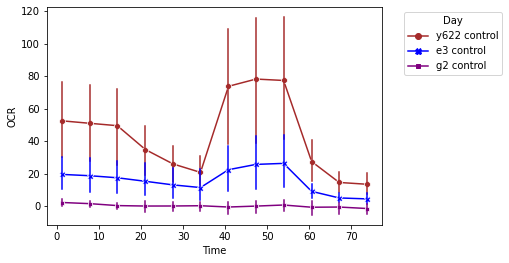

In [30]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_03202024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

df_temp = df[[x in set([ 'e3 choline', 'e3 control',
       'e3 rosiglitazone']) for x in df['Group']]]

#df_temp = df[[x in set([  'g2 choline', 'g2 control', 'g2 rosiglitazone']) for x in df['Group']]]

#df_temp = df[[x in set(['y622 choline', 'y622 control', 'y622 rosiglitazone']) for x in df['Group']]]

df_temp = df[[x in set([ 'y622 control', 'e3 control',
       'g2 control']) for x in df['Group']]]


colors = dict(zip(['Background', 'Unassigned', 'e3 choline', 'e3 control',
       'e3 rosiglitazone', 'g2 choline', 'g2 control', 'g2 rosiglitazone',
       'y622 choline', 'y622 control', 'y622 rosiglitazone'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink', 'red', 'brown', 'orange']))
sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.legend(title="Day", bbox_to_anchor=(1.05, 1), loc='upper left')


In [17]:
colors = dict(zip(['Background', 'Unassigned', 'e3 choline', 'e3 control',
       'e3 rosiglitazone', 'g2 choline', 'g2 control', 'g2 rosiglitazone',
       'y622 choline', 'y622 control', 'y622 rosiglitazone'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink', 'red', 'brown', 'orange']))

In [28]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[:2], axis=0)
oligomycin = np.sum(D[3:5], axis=0)
fccp = np.sum(D[6:8], axis=0)
antimycin = np.sum(D[9:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal
df['temp'] = proton_leak/atp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


y622 control vs. y622 rosiglitazone: t-test independent samples, P_val:7.309e-01 t=-3.520e-01
y622 control vs. y622 choline: t-test independent samples, P_val:2.994e-01 t=1.085e+00


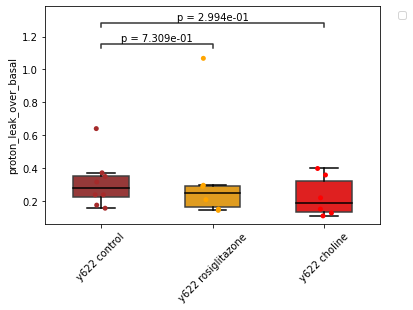

In [26]:
order = ['y622 control', 'y622 rosiglitazone', 'y622 choline']
pairs = [(('y622 control'), ('y622 rosiglitazone')), (('y622 control'), ('y622 choline'))]
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors, order, pairs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


e3 control vs. e3 rosiglitazone: t-test independent samples, P_val:8.335e-01 t=2.148e-01
e3 control vs. e3 choline: t-test independent samples, P_val:1.607e-01 t=1.495e+00


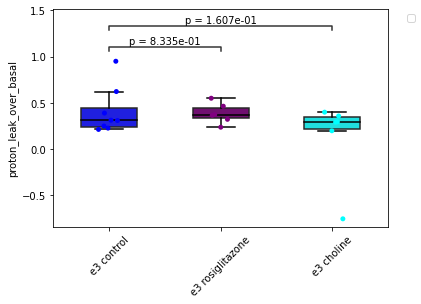

In [29]:
order = ['e3 control', 'e3 rosiglitazone', 'e3 choline']
pairs = [(('e3 control'), ('e3 rosiglitazone')), (('e3 control'), ('e3 choline'))]
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors, order, pairs)

In [ ]:

discard = set(['C03', 'C04', 'C10', 'F03', 'F04', 'F05', 'G02', 'G03' ,'G04', 'G06', 'G10', 'G11'])

df = df[[x not in discard for x in df['Well']]]

colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

df_temp = df#[[x in set(['Y622 CDP-choline', 'Y622 H2O']) for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


<Axes: xlabel='Time', ylabel='OCR'>

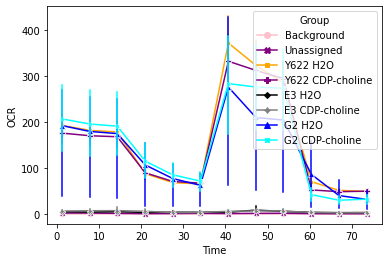

In [2]:
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

discard = set(['C03', 'C04', 'C10', 'F03', 'F04', 'F05', 'G02', 'G03' ,'G04', 'G06', 'G10', 'G11'])

df = df[[x not in discard for x in df['Well']]]

colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

df_temp = df#[[x in set(['Y622 CDP-choline', 'Y622 H2O']) for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


<Axes: xlabel='Time', ylabel='ECAR'>

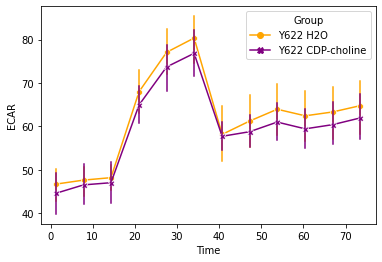

In [387]:
file_path = '../raw_data/seahorse/iN030620240_ABCA7KO_CDP-choline_04032024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

discard = set(['C03', 'C04', 'C10', 'F03', 'F04', 'F05', 'G02', 'G03' ,'G04', 'G06', 'G10', 'G11'])

df = df[[x not in discard for x in df['Well']]]

colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

df_temp = df[[x in set(['Y622 CDP-choline', 'Y622 H2O']) for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='ECAR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


In [4]:
T = [[compute_integral(df_temp, y, x, 'ECAR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[:2], axis=0)
glucose = np.sum(D[3:5], axis=0)
glycolysis = glucose - basal

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), glucose.reshape(-1,1), glycolysis.reshape(-1,1)), axis=1))
df.columns = ['basal', 'glucose', 'glycolysis']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 CDP-choline vs. Y622 H2O: t-test independent samples, P_val:4.134e-01 t=-8.413e-01


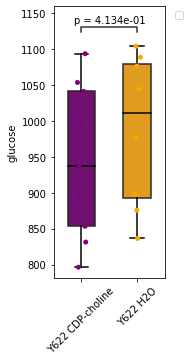

In [385]:
plt.figure(figsize=(2,5))
colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

plot_boxplot_by_treatment(df, 'glucose', colors, colors)

In [5]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[:2], axis=0)
oligomycin = np.sum(D[3:5], axis=0)
fccp = np.sum(D[6:8], axis=0)
antimycin = np.sum(D[9:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal
df['temp'] = proton_leak/atp

/state/partition1/slurm_tmp/25757204.0.0/ipykernel_557118/1773255853.py:30: RuntimeWarning: invalid value encountered in divide
  df['max_over_basal'] = maximal/true_basal
/state/partition1/slurm_tmp/25757204.0.0/ipykernel_557118/1773255853.py:31: RuntimeWarning: invalid value encountered in divide
  df['atp_over_basal'] = atp/true_basal
/state/partition1/slurm_tmp/25757204.0.0/ipykernel_557118/1773255853.py:32: RuntimeWarning: invalid value encountered in divide
  df['proton_leak_over_basal'] = proton_leak/true_basal
/state/partition1/slurm_tmp/25757204.0.0/ipykernel_557118/1773255853.py:33: RuntimeWarning: invalid value encountered in divide
  df['temp'] = proton_leak/atp


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 CDP-choline vs. Y622 H2O: t-test independent samples, P_val:3.583e-04 t=4.584e+00


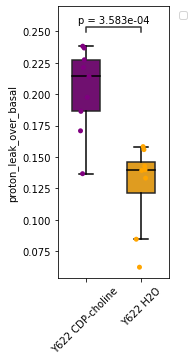

In [6]:
plt.figure(figsize=(2,5))
colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors)

In [7]:
def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'grp', showfliers=False, y = y_val, dodge = True, order = [ 'G2 CDP-choline', 'G2 H2O'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = [ 'G2 CDP-choline', 'G2 H2O'])

    pairs = [(('G2 H2O'), ('G2 CDP-choline'))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = [ 'G2 CDP-choline', 'G2 H2O'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


G2 CDP-choline vs. G2 H2O: t-test independent samples, P_val:2.743e-02 t=2.628e+00


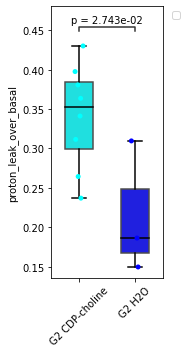

In [8]:
plt.figure(figsize=(2,5))
colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Y622 CDP-choline vs. Y622 H2O: t-test independent samples, P_val:1.158e-01 t=-1.669e+00


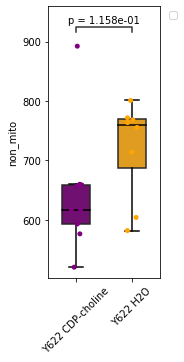

In [393]:
plt.figure(figsize=(2,5))
colors = dict(zip(['E3 CDP-choline', 'E3 H2O', 'G2 CDP-choline', 'G2 H2O', 'Y622 CDP-choline', 'Y622 H2O', 'Unassigned', 'Background'], [ 'grey', 'black', 'cyan', 'blue', 'purple', 'orange', 'purple', 'pink']))

plot_boxplot_by_treatment(df, 'non_mito', colors, colors)

In [362]:
def compute_slope(point1, point2):
    m = (point2[1]-point1[1]) / (point2[0]-point1[0])
    return m
   
def get_points(last_point, data, measure):
    prev_point = last_point - 1
    point1 = np.array((np.array(data[data['Measurement']==prev_point]['Time']), np.array(data[data['Measurement']==prev_point][measure]))).reshape(-1)
    point2 = np.array((np.array(data[data['Measurement']==last_point]['Time']), np.array(data[data['Measurement']==last_point][measure]))).reshape(-1)
    return point1, point2

def compute_b(point, slope):
    b = point[1]-(slope*point[0])
    return b

def integrate(point1, point2, slope, b):
    v2 = (0.5*slope * point2[0]**2) + (b * point2[0])
    v1 = (0.5*slope * point1[0]**2) + (b * point1[0])
    return v2-v1

def compute_integral(data, well_id, last_point, measure): 
    temp = data[data['Well']==well_id]
    point1, point2 = get_points(last_point, temp, measure)
    slope = compute_slope(point1, point2)
    b = compute_b(point1, slope)
    return integrate(point1, point2, slope, b)

from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'grp', showfliers=False, y = y_val, dodge = True, order = ['E3 25k', 'Y622 25k', 'G2 25k'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['E3 25k', 'Y622 25k', 'G2 25k'])

    pairs = [(("E3 25k"), ("Y622 25k")), (("E3 25k"), ("G2 25k"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = ['E3 25k', 'Y622 25k', 'G2 25k'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')


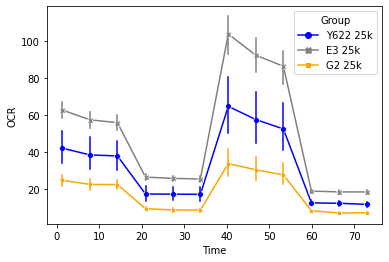

In [366]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03132024_edited.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'orange','blue']))

df.head()

df_temp = df[['25k' in x for x in df['Group']]]
df_temp = df_temp[[x not in set(['G02', 'G05', 'F02', 'F03', 'F04']) for x in df_temp['Well']]]
#df_temp = df_temp[np.invert(df_temp['Group']=='G2 25k')]
sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation
plt.savefig('../pdf_figures/seahorse_trace.pdf')

In [367]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[1:2], axis=0)
oligomycin = np.sum(D[4:5], axis=0)
fccp = np.sum(D[7:8], axis=0)
antimycin = np.sum(D[10:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:3.382e-01 t=9.839e-01
E3 25k vs. G2 25k: t-test independent samples, P_val:6.212e-11 t=1.365e+01


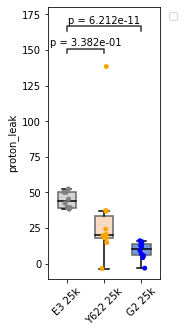

In [369]:
plt.figure(figsize=(2,5))
colors2 = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'blue','orange']))
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'lightgrey' , 'cornflowerblue', 'peachpuff']))
plot_boxplot_by_treatment(df, 'proton_leak', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

<Axes: xlabel='Time', ylabel='OCR'>

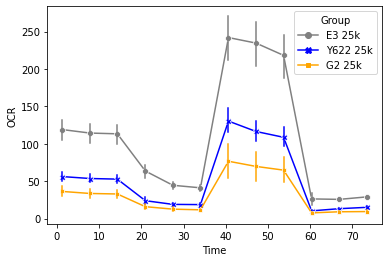

In [370]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_50k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'orange','blue']))

df.head()

df_temp = df[['25k' in x for x in df['Group']]]
df_temp = df_temp[[x not in set(['B11', 'E02', 'E03', 'G02', 'G03', 'G04', 'F09', 'G08', 'G09', 'G11']) for x in df_temp['Well']]]

#df_temp = df_temp[np.invert(df_temp['Group']=='G2 25k')]
sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95, err_style='bars')  # 68% CI for roughly one standard deviation


In [371]:
T = [[compute_integral(df_temp, y, x, 'OCR') for x in range(2,13)] for y in np.unique(df_temp['Well'])]
D = np.vstack(T)
D = D.T

basal = np.sum(D[1:2], axis=0)
oligomycin = np.sum(D[4:5], axis=0)
fccp = np.sum(D[7:8], axis=0)
antimycin = np.sum(D[10:11], axis=0)

df = pd.DataFrame(np.concatenate((basal.reshape(-1,1), oligomycin.reshape(-1,1), fccp.reshape(-1,1), antimycin.reshape(-1,1)), axis=1))
df.columns = ['basal', 'oligomycin', 'fccp', 'antimycin']
df['well'] = np.unique(df_temp['Well'])

dictionary = dict(zip(df_temp['Well'], df_temp['Group']))
df['grp'] = [dictionary[x] for x in df['well']]

non_mito = antimycin
true_basal = basal-non_mito
proton_leak = oligomycin - non_mito
maximal = fccp - non_mito
spare = maximal - true_basal
atp = true_basal - proton_leak

df['non_mito'] = non_mito
df['true_basal'] = true_basal
df['proton_leak'] = proton_leak
df['maximal'] = maximal
df['spare'] = spare
df['atp'] = atp
df['max_over_basal'] = maximal/true_basal
df['atp_over_basal'] = atp/true_basal
df['proton_leak_over_basal'] = proton_leak/true_basal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.029e-06 t=7.405e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.184e-05 t=6.842e+00


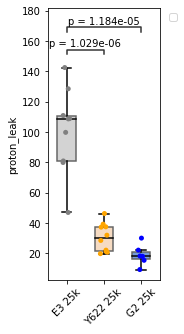

In [373]:
plt.figure(figsize=(2,5))
colors2 = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'grey' , 'blue','orange']))
colors = dict(zip(['E3 25k', 'G2 25k', 'Y622 25k'], [ 'lightgrey' , 'cornflowerblue', 'peachpuff']))
plot_boxplot_by_treatment(df, 'proton_leak', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.616e-03 t=3.522e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:5.307e-04 t=4.565e+00


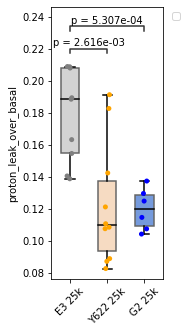

In [332]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


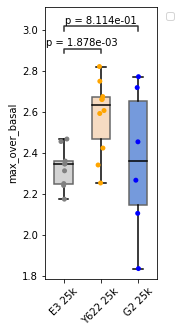

In [114]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


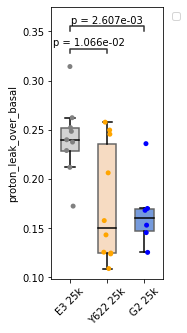

In [85]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)
#plt.savefig('../pdf_figures/basal.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:2.739e-03 t=3.469e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.576e-08 t=9.636e+00


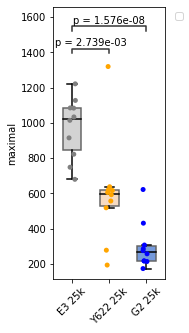

In [23]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'maximal', colors, colors2)
#plt.ylim(0,.4)
plt.savefig('../pdf_figures/maximal.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


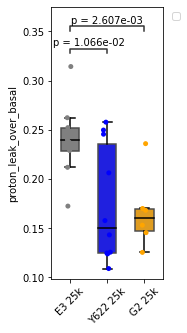

In [206]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


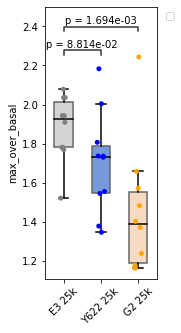

In [202]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


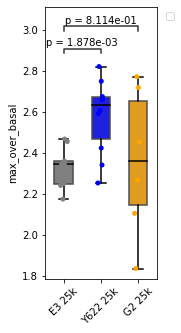

In [207]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.066e-02 t=2.868e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:2.607e-03 t=3.713e+00


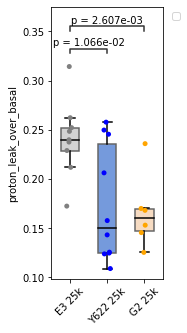

In [188]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


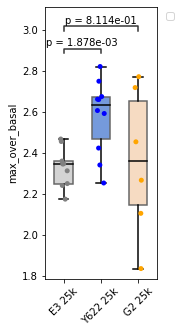

In [189]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 50k vs. Y622 50k: t-test independent samples, P_val:6.601e-01 t=4.481e-01
E3 50k vs. G2 50k: t-test independent samples, P_val:3.535e-02 t=-2.313e+00


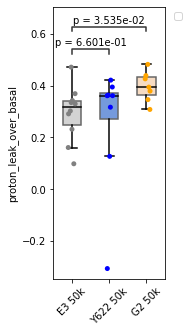

In [179]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


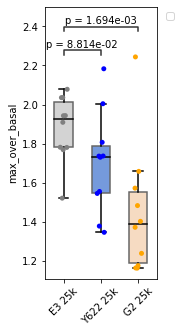

In [168]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=6.100e+00


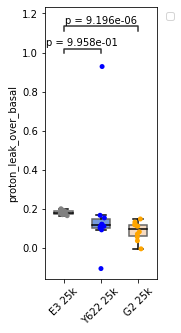

In [169]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.878e-03 t=-3.675e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:8.114e-01 t=-2.435e-01


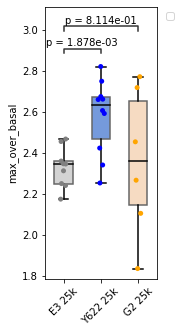

In [164]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.645e-02 t=2.645e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.743e-01 t=-7.308e-01


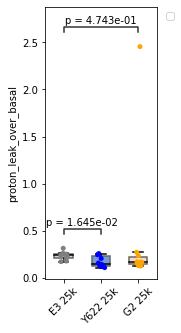

In [119]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)
#plt.ylim(0,.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=-5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=-6.100e+00


(0.0, 1.0)

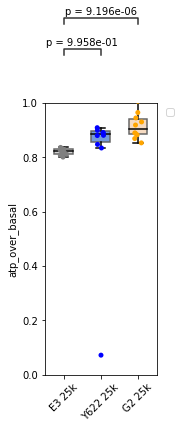

In [123]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)
plt.ylim(0,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.645e-02 t=-2.645e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:4.743e-01 t=7.308e-01


(0.0, 1.0)

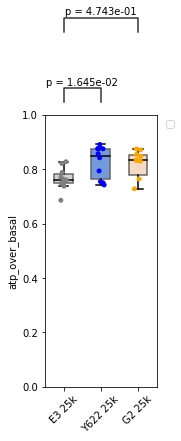

In [116]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)
plt.ylim(0,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:8.814e-02 t=1.803e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.694e-03 t=3.685e+00


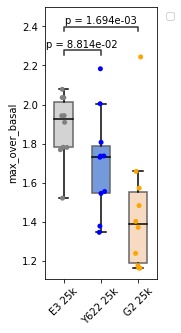

In [92]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'max_over_basal', colors, colors2)

In [65]:
plt.figure(figsize=(2,5))

plot_boxplot_by_treatment(df, 'proton_leak_over_basal', colors, colors2)

ValueError: Could not interpret input 'grp'

<Figure size 144x360 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:1.116e-02 t=2.827e+00
E3 25k vs. G2 25k: t-test independent samples, P_val:1.238e-09 t=1.135e+01


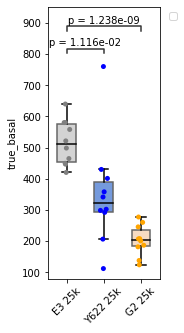

In [243]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'true_basal', colors, colors2)

array([325.2681095 , 669.12336741, 360.52118361, 181.49424014,
       123.7749771 , 265.59035273, 358.4786103 , 304.09568361,
        20.97727813, 255.89892501, 470.49336678, 530.51793004,
       421.41756668, 478.78877446, 370.13077138, 382.77899213,
       413.95519459, 466.57787969, 342.67755155, 357.62171081,
       225.82304792, 218.08412233, 196.20854585, 166.03363844,
       199.64624075, 138.51836153, 176.95115049, 257.78749913,
       154.85784452, 113.66816518])

In [239]:
np.argwhere((atp/true_basal)>1)

array([[ 4],
       [25]])

In [241]:
df.iloc[4]

basal                     257.586944
oligomycin                133.811967
fccp                      339.287465
antimycin                 145.775797
well                             B11
grp                         Y622 25k
non_mito                  145.775797
true_basal                111.811147
proton_leak                -11.96383
maximal                   193.511668
spare                      81.700521
atp                       123.774977
max_over_basal              1.730701
atp_over_basal                 1.107
proton_leak_over_basal        -0.107
Name: 4, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


E3 25k vs. Y622 25k: t-test independent samples, P_val:9.958e-01 t=-5.279e-03
E3 25k vs. G2 25k: t-test independent samples, P_val:9.196e-06 t=-6.100e+00


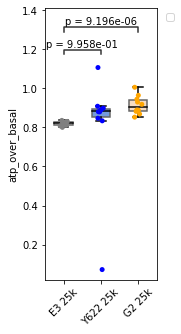

In [235]:
plt.figure(figsize=(2,5))
plot_boxplot_by_treatment(df, 'atp_over_basal', colors, colors2)

In [136]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

def plot_boxplot_by_treatment(d, y_val, colors, colors2):
    

    ax = sns.boxplot(data = d, x = 'Group', showfliers=False, y = y_val, dodge = True, order = ['E3 25k', 'Y622 25k', 'G2 25k'], palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=d, x='grp', y=y_val, palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['E3 25k', 'Y622 25k', 'G2 25k'])

    pairs = [(("E3 25k"), ("Y622 25k")), (("E3 25k"), ("G2 25k"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=d, x='grp', y=y_val, order = ['E3 25k', 'Y622 25k', 'G2 25k'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')


In [116]:
df_temp['Measurement']

18       1
19       1
20       1
21       1
22       1
        ..
1134    12
1135    12
1136    12
1137    12
1138    12
Name: Measurement, Length: 360, dtype: int64

In [102]:
df_temp

,Measurement,Well,Group,Time,OCR,ECAR,PER
18,1,B07,Y622 25k,1.302014,41.233374,9.248245,0
19,1,B08,Y622 25k,1.302014,76.612055,10.913393,0
20,1,B09,Y622 25k,1.302014,49.529537,12.207213,0
21,1,B10,Y622 25k,1.302014,27.093456,7.158849,0
22,1,B11,Y622 25k,1.302014,19.512938,5.763437,0
...,...,...,...,...,...,...,...
1134,12,G07,G2 25k,72.914893,6.416389,8.889256,0
1135,12,G08,G2 25k,72.914893,7.105036,10.039441,0
1136,12,G09,G2 25k,72.914893,8.069530,13.565325,0
1137,12,G10,G2 25k,72.914893,7.784274,9.537526,0


41.95861716838372

-0.5570164304084958

array([7.78831964])

In [67]:
point2[0]

114    7.78832
Name: Time, dtype: float64

In [38]:
sheet_name = 'Operation Log'  
df_log = pd.read_excel(file_path, sheet_name=sheet_name)


In [40]:
df

,Measurement,Well,Group,Time,OCR,ECAR,PER
0,1,A01,Background,1.302014,0.0,0.0,0
1,1,A02,Background,1.302014,0.0,0.0,0
2,1,A03,Background,1.302014,0.0,0.0,0
3,1,A04,Background,1.302014,0.0,0.0,0
4,1,A05,Background,1.302014,0.0,0.0,0
...,...,...,...,...,...,...,...
1147,12,H08,Background,72.914893,0.0,0.0,0
1148,12,H09,Background,72.914893,0.0,0.0,0
1149,12,H10,Background,72.914893,0.0,0.0,0
1150,12,H11,Background,72.914893,0.0,0.0,0


In [39]:
df_log

,Instruction Name,Command Name,Command Index,Start Time,End Time,Completion Status
0,Home,Home,0,3/13/2024 2:10:23 PM,3/13/2024 2:10:28 PM,Success
1,Load Cartridge,LoadProbes,0,3/13/2024 2:10:28 PM,3/13/2024 2:12:38 PM,Success
2,Initialization,Calibrate,1,3/13/2024 2:12:38 PM,3/13/2024 2:33:07 PM,Success
3,PreCalibration,PreCalibrate,1,3/13/2024 2:12:39 PM,3/13/2024 2:25:55 PM,Success
4,OffsetCalibrate,OffsetCalibrate,1,3/13/2024 2:25:59 PM,3/13/2024 2:26:22 PM,Success
5,CoarseCalibrate,CoarseCalibrate,1,3/13/2024 2:25:59 PM,3/13/2024 2:29:18 PM,Success
6,FineCalibrate,FineCalibrate,1,3/13/2024 2:29:18 PM,3/13/2024 2:33:03 PM,Success
7,Load Plate,LoadPlate,0,3/13/2024 2:33:07 PM,3/13/2024 2:36:14 PM,Success
8,Equilibrate,Equilibrate,0,3/13/2024 2:36:15 PM,3/13/2024 2:48:47 PM,Success
9,Baseline,Mix,2,3/13/2024 2:48:47 PM,3/13/2024 2:51:54 PM,Success


<Axes: xlabel='Time', ylabel='OCR'>

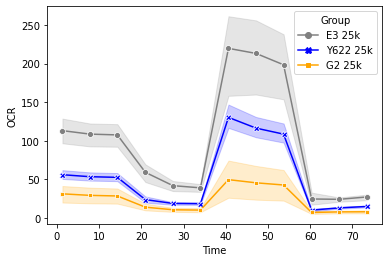

In [34]:
file_path = '../raw_data/seahorse/iN_ABCA7KO_25k_25k_03272024_iNbatch02282024.xlsx'
sheet_name = 'Rate'  
df = pd.read_excel(file_path, sheet_name=sheet_name)

df.head()

df_temp = df[['25k' in x for x in df['Group']]]

sns.lineplot(data=df_temp, x='Time', y='OCR', hue='Group', style='Group', palette = colors, markers=True, dashes=False, ci=95)#, #err_style='bars')  # 68% CI for roughly one standard deviation


,Measurement,Well,Group,Time,OCR,ECAR,PER
0,1,A01,Background,1.302014,0.0,0.0,0
1,1,A02,Background,1.302014,0.0,0.0,0
2,1,A03,Background,1.302014,0.0,0.0,0
3,1,A04,Background,1.302014,0.0,0.0,0
4,1,A05,Background,1.302014,0.0,0.0,0


In [10]:
np.unique(df['Group'])

array(['Background', 'E3 25k', 'E3 50k', 'G2 25k', 'G2 50k', 'Y622 25k',
       'Y622 50k'], dtype=object)

<Axes: xlabel='Time', ylabel='OCR'>

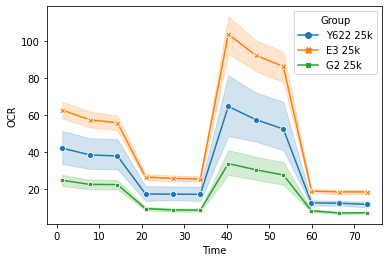

<Axes: xlabel='Time', ylabel='OCR'>

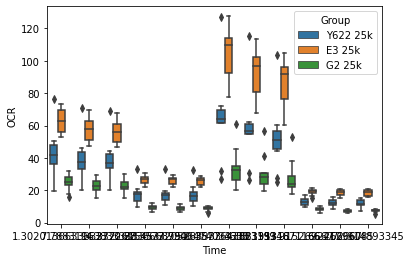

In [24]:
sns.boxplot(data = df_temp, x = 'Time', y = 'OCR', hue = 'Group')

In [17]:
help(sns.lineplot)

Help on function lineplot in module seaborn.relational:

lineplot(*, x=None, y=None, hue=None, size=None, style=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, err_style='band', err_kws=None, legend='auto', ax=None, **kwargs)
    Draw a line plot with possibility of several semantic groupings.
    
    The relationship between ``x`` and ``y`` can be shown for different subsets
    of the data using the ``hue``, ``size``, and ``style`` parameters. These
    parameters control what visual semantics are used to identify the different
    subsets. It is possible to show up to three dimensions independently by
    using all three semantic types, but this style of plot can be hard to
    interpret and is often ineffective. Using redundant semantics (i.e. both
    ``hue`` and ``style`` for the same variable) can be help